# Attention Assignment
Alexandria Benedict 12/5

In [28]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import files

uploaded = files.upload()



#df = pd.read_csv(ita_path,sep='\t',names=['eng','it','etc'])

Saving ita.txt to ita.txt


# Question 1

In [32]:
ita_path = './ita.txt'
df = pd.read_csv(ita_path,sep='\t',names=['eng','it','etc'])
df.drop('etc', inplace=True, axis=1)
print(df)
df.to_csv('eng-it.txt', header=None, index=None, sep='\t', mode='a')

                                                      eng                                                 it
0                                                     Hi.                                              Ciao!
1                                                    Run!                                             Corri!
2                                                    Run!                                             Corra!
3                                                    Run!                                           Correte!
4                                                    Who?                                               Chi?
...                                                   ...                                                ...
341549  If you want to sound like a native speaker, yo...  Se vuoi sembrare un madrelingua, devi essere d...
341550  If you want to sound like a native speaker, yo...  Se vuoi sembrare un madrelingua, devi essere d...
341551  If someone 

In [4]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [5]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [11]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('./%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [12]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [33]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'it', True)
print(random.choice(pairs))

Reading lines...
Read 341554 sentence pairs
Trimmed to 31079 sentence pairs
Counting words...
Counted words:
it 5260
eng 3091
['lo ripareremo .', 'we re going to fix that .']


In [16]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [17]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [18]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [19]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [20]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [21]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [22]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [23]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [24]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [34]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [35]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

6m 17s (- 88m 3s) (5000 6%) 2.8874
12m 39s (- 82m 13s) (10000 13%) 2.2535
18m 55s (- 75m 40s) (15000 20%) 1.8840
25m 8s (- 69m 7s) (20000 26%) 1.6903
31m 28s (- 62m 56s) (25000 33%) 1.4996
37m 44s (- 56m 36s) (30000 40%) 1.3346
43m 54s (- 50m 11s) (35000 46%) 1.2213
50m 3s (- 43m 48s) (40000 53%) 1.1130
56m 25s (- 37m 37s) (45000 60%) 1.0017
62m 46s (- 31m 23s) (50000 66%) 0.9245
69m 6s (- 25m 7s) (55000 73%) 0.8867
75m 37s (- 18m 54s) (60000 80%) 0.8312
82m 7s (- 12m 38s) (65000 86%) 0.7460
88m 33s (- 6m 19s) (70000 93%) 0.6949
95m 4s (- 0m 0s) (75000 100%) 0.6606


In [36]:
evaluateRandomly(encoder1, attn_decoder1)

> vi state avvicinando .
= you re getting closer .
< you re getting closer . <EOS>

> io sono insoddisfatta del mio nuovo appartamento .
= i m dissatisfied with my new apartment .
< i m dissatisfied with my new apartment . <EOS>

> ti stai avvicinando .
= you re getting closer .
< you re getting closer . <EOS>

> non sono abituata a questo freddo .
= i m not used to this cold .
< i m not used to this cold . <EOS>

> sono molto dispiaciuta di averlo fatto .
= i m very sorry i did that .
< i m very sorry that did that . <EOS>

> tom non mi manchera .
= i m not going to miss tom .
< i m not going to miss that . <EOS>

> siamo disposte ad aiutarti .
= we re willing to help you .
< we re willing to help you . <EOS>

> lui e molto arrabbiato con voi .
= he s very angry with you .
< he s very angry with you . <EOS>

> ha sete di celebrita .
= he is thirsty for fame .
< he is thirsty with you . <EOS>

> sono prudente .
= i m careful .
< they re careful . <EOS>



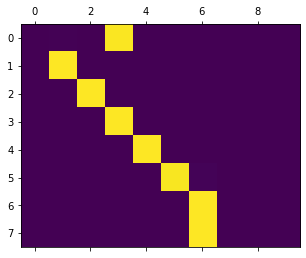

In [41]:
%matplotlib inline
output_words, attentions = evaluate(encoder1, attn_decoder1, "lui e molto arrabbiato con voi .")
plt.matshow(attentions.numpy())

input = vi state avvicinando .
output = you re getting closer . <EOS>


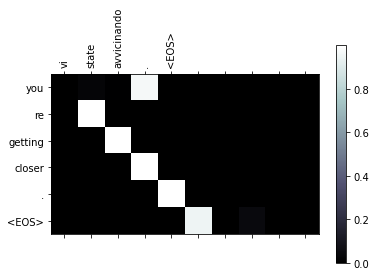

In [42]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

%matplotlib inline
evaluateAndShowAttention("vi state avvicinando .")


# Question 2

9m 11s (- 128m 45s) (5000 6%) 2.8270
18m 16s (- 118m 49s) (10000 13%) 2.1634
27m 31s (- 110m 4s) (15000 20%) 1.7940
36m 44s (- 101m 1s) (20000 26%) 1.5328
45m 59s (- 91m 58s) (25000 33%) 1.3171
55m 17s (- 82m 56s) (30000 40%) 1.1862
64m 38s (- 73m 52s) (35000 46%) 1.0448
73m 56s (- 64m 41s) (40000 53%) 0.9350
83m 15s (- 55m 30s) (45000 60%) 0.8456
92m 39s (- 46m 19s) (50000 66%) 0.7389
101m 56s (- 37m 4s) (55000 73%) 0.6731
111m 16s (- 27m 49s) (60000 80%) 0.6159
120m 36s (- 18m 33s) (65000 86%) 0.5706
129m 58s (- 9m 17s) (70000 93%) 0.5271
139m 15s (- 0m 0s) (75000 100%) 0.4879


<Figure size 432x288 with 0 Axes>

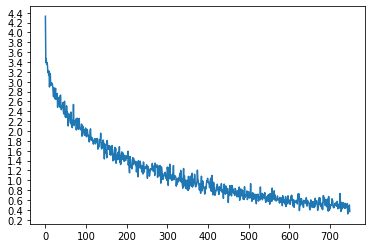

In [43]:
hidden_size = 356
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder2, attn_decoder2, 75000, print_every=5000)

In [44]:
evaluateRandomly(encoder2, attn_decoder2)

> ha in mente qualcosa .
= he s up to something .
< he s something something . <EOS>

> sono abituata ad alzarmi presto .
= i m accustomed to getting up early .
< i m used to getting up early . <EOS>

> non sono ancora pronto .
= i m not ready yet .
< i m not ready yet . <EOS>

> lei sta vivendo alla giornata .
= she is living hand to mouth .
< she is living to to her . . <EOS>

> voi siete molto curiose .
= you re very curious .
< you re very curious . <EOS>

> io mi dimentico sempre i nomi delle persone .
= i m always forgetting people s names .
< i m always forgetting people s names . <EOS>

> tu sei sofisticato .
= you re sophisticated .
< you re sophisticated . <EOS>

> sei cosi forte .
= you re so strong .
< you re so strong . <EOS>

> tu sei metodico .
= you re methodical .
< you re methodical . <EOS>

> e un giardiniere .
= he s a gardener .
< he s a gardener . <EOS>



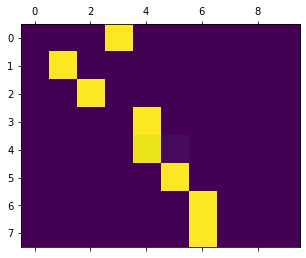

In [46]:
%matplotlib inline
output_words, attentions = evaluate(encoder2, attn_decoder2, "lui e molto arrabbiato con voi .")
plt.matshow(attentions.numpy())

input = vi state avvicinando .
output = you re getting closer . <EOS>


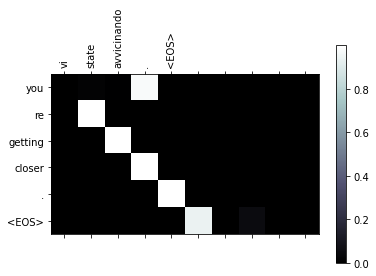

In [47]:
%matplotlib inline
evaluateAndShowAttention("vi state avvicinando .")


#Question 3

For question 2, I increased the hidden_size, or number of hidden nodes, for the training to be 356, from the previous 256. This caused the actual training time to be a bit longer, going from approximately 95 minutes to 139 minutes. After evaluating the second experiment of Question 2, it did affect the focus of attention slightly as seen on the graphs. The first experiment had a more diagonal line, but also more of a cluster in column 6, whereas the second experiment had the similar pattern for both columns 4 and 6. In the future, I would like to also test what greatly decreasing the hidden node sizes would cause in more experiments.